In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm as progressbar
from transformers import AutoTokenizer, AutoModel
import pickle
import torch
import torch.nn.functional as F

In [2]:
torch.__version__

'2.2.1+cu121'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Loading preprocessed deduped data

In [5]:
df = pd.read_csv('../preprocessed/attribute.seqs.tsv', sep = '\t', names=['name', 'text']).dropna()

In [6]:
classes=df.groupby(by=["name"]).count().reset_index()
classes_sorted = classes.sort_values(by='text', ascending=True) #.name.values
classes_sorted.tail(5)

,name,text
22,isolate_run,4483
29,sample_comment_sam,5003
0,bio_material_sam,9295
24,misc_param_sam,10739
10,description_sam,17233


### Making directories to keep results

In [7]:
!mkdir -p ../results/sbert-similarity-matrics ../results/sbert-similar-pairs

### Loading pretrained tokenizer and model

For model tuning specs see [SBERT here](https://www.sbert.net/docs/pretrained_models.html)  
For "naked" model usage see [huggingface](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)

In [8]:
NAMESPACE='sbert'

In [9]:
## all-mpnet-base-v2 does not fit into my 12GB CUDA together with vectors

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(device)

<img src='img/SBERT-models.png' height="300px">

## Checking vocabulary overlap  
As BERT tokenizes into "morphemes", will consider word an OOV if it tokenizes into number of tokens more than 1/2 of original length,
which is not perfect.

In [10]:
%load_ext autoreload
%autoreload 2

from vocaverlap import VocabOverlap

In [11]:
%%time        
def if_oov(t):
    tt = tokenizer.tokenize(t)
    if tt is None or len(tt) == 0:
        return True
    if len(tt) == 1:
        return False
    if (len(tt) * 1.0)/len(t) >= 0.5:
        return True
    return False

vo = VocabOverlap(df[['name', 'text']].values).apply(if_oov)

with open(f'../preprocessed/attribute.token-freqs.{NAMESPACE}.info.pickle', 'wb') as f:
    pickle.dump(vo.info, f, protocol=pickle.HIGHEST_PROTOCOL)    


CPU times: user 4.26 s, sys: 40.2 ms, total: 4.3 s
Wall time: 4.27 s


In [14]:
distribution = []

for k, v in vo.info.items():
    distribution.append([k, 1-v['oov_tokens']/v['tokens'], 1-v['oov_uniq']/v['uniq']])

distribution = sorted(distribution, key=lambda x :x[2], reverse=True)
df_distribution = pd.DataFrame(distribution, columns = ['name', 'r_tokens', 'r_uniq'])

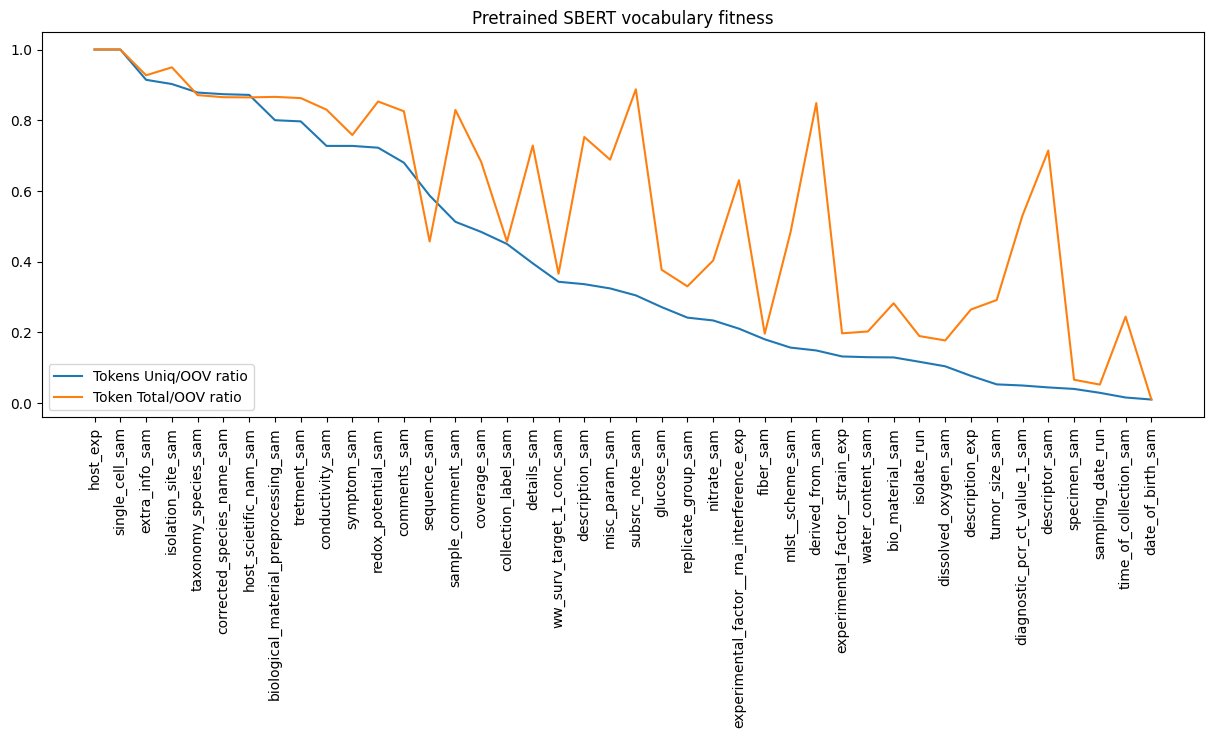

In [15]:
plt.figure(figsize=(15,5))
plt.plot(df_distribution['r_uniq'])
plt.plot(df_distribution['r_tokens'])
plt.title(f'Pretrained {NAMESPACE.upper()} vocabulary fitness')
plt.xticks(range(0, df_distribution.shape[0]), df_distribution['name'], rotation='vertical')
plt.legend(['Tokens Uniq/OOV ratio', 'Token Total/OOV ratio'], loc='lower left')
plt.show()

In [16]:
good_overlap = df_distribution[df_distribution.r_uniq>0.75]
good_overlap.to_csv(f'../preprocessed/attribute.{NAMESPACE}.75.overlap.tsv', sep = '\t', index=False, header=False)

### Making similarity matrixes and top similar pairs per attribute

In [17]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [18]:
%%time
for a in progressbar(classes_sorted.name.values, total=len(classes_sorted), file=sys.stdout):
    sentences = df[df.name == a].text.values.tolist()
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)

    matrix = np.matmul(embeddings, embeddings.T)
    np.save(f'../results/{NAMESPACE}-similarity-matrics/{NAMESPACE}-{a}.similarity-score-matrix', matrix, allow_pickle = False)

    scores = []
    x = np.tril(matrix, k=-1)
    for r, c in zip(*np.where(x>0.7)):
        scores.append([a, x[r, c], sentences[r], sentences[c]])
        
    pd.DataFrame(scores, columns=['attr', 
                                  'score', 
                                  's1', 
                                  's2']).to_csv(f'../results/{NAMESPACE}-similar-pairs/{NAMESPACE}-{a}.similar-pairs.tsv', sep = '\t', index=False)

100%|██████████| 42/42 [25:54<00:00, 37.01s/it] 
CPU times: user 5h 24min 32s, sys: 6h 47min 54s, total: 12h 12min 27s
Wall time: 25min 54s


In [ ]:
!ls -lh ../results/sbert-similarity-matrics/*.similarity-score-matrix.*